#### package

In [2]:
from typing import Optional, Callable, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba import Mamba, MambaConfig
from loss_functions import get_loss_fn
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from sklearn.preprocessing import PowerTransformer
from dataclasses import dataclass
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import SGD

2025-07-31 10:18:07.582545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-31 10:18:08.061182: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: initialization failed

#### hyperparameters

In [2]:
save_dir = '0730_2330/'
use_cuda = True
seed_num = random.randint(0, 999999)
n_steps=10
window=15
patience = 100
val_ratio = 0.2
epochs = 1000
loss_fcn = "mse"

lr = 0.0005
wd = 1e-5
hidden = 128
layer = 4
n_test = 350
ts_code = 2330
risk_free = 0.017

#### Import Data

In [3]:
data = pd.read_csv(str(ts_code)+"_value"+'.csv')
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y/%m/%d')

# 加入星期幾（0=星期一, 6=星期日）
data['day_of_week'] = data['trade_date'].dt.dayofweek

# 加入月份（1～12）
data['month'] = data['trade_date'].dt.month

returns = data['close_TW_roc']

tp=[5, 10, 20]

for tp in tp:
    # 移動平均報酬率
    data[f'returns_ma_{tp}'] = returns.rolling(window=tp).mean()
    
    # 指數移動平均
    data[f'returns_ema_{tp}'] = returns.ewm(span=tp, adjust=False).mean()

    # 報酬率波動度
    data[f'returns_volatility_{tp}'] = returns.rolling(window=tp).std()

    # 報酬率的 Z-score
    mean = returns.rolling(window=tp).mean()
    std = returns.rolling(window=tp).std()
    data[f'returns_zscore_{tp}'] = (returns - mean) / std

data = data.dropna().reset_index(drop=True)

'''
['trade_date', 'stock_no', 'stock_name', 'stock_type', 
'open_TW', 'close_TW', close_TW_roc, 'h_TW', 'l_TW', 'vol_TW', 'CBOE_SKEW_INDEX', 
'CBOE_Volatility_INDEX', 'COPPER_F', 'COPPER', 'GOLD_F', 
'GOLD', 'OIL_F', 'OIL', 'SP_F', 'SILVER_F', 'SILVER', 
'TWII', 'IXIC', 'GSPC', 'DJI', 'NYSE', 'RUSSELL', 'SSE', 
'FCHI', 'FTSE', 'GDAXI', 'Nikkei_F', 'IXIC_F', 'DJI_F', 
'S_P_F', 'USDX_F', 'JPY', 'GBP', 'HKD', 'CNY', 'AUD', 
'TWD', 'EUR', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS1', 
'DAAA', 'DBAA', 'DGS3MO', 'DGS6MO', 'DGS1.1', 'DCOILWTICO', 
'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 
'DE6', 'DCOILWTICO_rel_change', 'day_of_week', 'month']
'''

index = ['open_TW', 'close_TW', 'h_TW', 'l_TW', 'vol_TW', 'CBOE_SKEW_INDEX', 
'CBOE_Volatility_INDEX', 'TWII', 'DJI', 'NYSE', 'TWD', 'CNY', 'day_of_week', 'month',
"returns_ma_5", "returns_ema_5", "returns_volatility_5","returns_zscore_5",
"returns_ma_10", "returns_ema_10", "returns_volatility_10", "returns_zscore_10",
"returns_ma_20", "returns_ema_20", "returns_volatility_20", "returns_zscore_20"]

# 拆離 label 欄位

ratechg = data['close_TW_roc'].values

features = data[index].values
num_samples = features.shape[0]
# num_samples: 2520

# 定義 horizon 數
horizon = n_steps

X_list, y_list = [], []
for i in range(num_samples - window - horizon + 1):
    X_win = features[i : i + window]                        # shape: [window, features]
    t = np.arange(window).reshape(-1, 1)  # shape: [window, 1]
    sin_t = np.sin(t / 10000)
    cos_t = np.cos(t / 10000)
    time_encoding = np.concatenate([sin_t, cos_t], axis=1)    # shape: [window, 2]

    X_win = np.concatenate([X_win, time_encoding], axis=1) 
    y_future = ratechg[i + window : i + window + horizon]     # shape: [horizon]
    X_list.append(X_win)
    y_list.append(y_future)

trainX = np.array(X_list[:-n_test])
trainy = np.array(y_list[:-n_test])
testX = np.array(X_list[-n_test:])
testy = np.array(y_list[-n_test:])

# trainX.shape: (2146, 15, 61)  2146 = num_samples - window - horizon + 1
# trainy.shape: (2146, 10)
# testX.shape: (350, 15, 61)
# testy.shape: (350, 10)

#### train / val

In [4]:
val_size = int(len(trainX) * val_ratio)

valX = trainX[-val_size:]
valy = trainy[-val_size:]

trainX = trainX[:-val_size]
trainy = trainy[:-val_size]

# trainX.shape: (1717, 15, 61)
# trainy.shape: (1717, 10)
# valX.shape: (429, 15, 61)
# valy.shape: (429, 10)

In [5]:
device = torch.device("cuda" if use_cuda else "cpu")

trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
trainy = torch.tensor(trainy, dtype=torch.float32).to(device)

valX = torch.tensor(valX, dtype=torch.float32).to(device)
valy = torch.tensor(valy, dtype=torch.float32).to(device)

testX = torch.tensor(testX, dtype=torch.float32).to(device)
testy = torch.tensor(testy, dtype=torch.float32).to(device)

+ trainX
+ trainy
+ valX
+ valy
+ testX
+ testy

#### 模型

In [6]:
class Net(nn.Module):
    """
    多層 Mamba 時序模型，用於序列輸入特徵的未來預測。

    參數:
        in_dim (int): features 數量
        horizon (int): 模型預測的未來時間步數（輸出維度）。
        hidden (int): 中間表示層（latent layer）的維度。
        layer (int): Mamba block 的堆疊層數。

    屬性:
        config (MambaConfig): 用於初始化 Mamba 模型的配置。
        proj_in (nn.Linear): 將輸入特徵從 in_dim 投影到 hidden 維度。
        mamba (Mamba): 多層 Mamba 模型，用於處理時間序列資料。
        pool (nn.AdaptiveAvgPool1d): 算平均
        head (nn.Linear): 轉換為 horizon 維度的預測向量。
    """
    in_dim: int
    horizon: int
    hidden: int
    layer: int

    config: MambaConfig
    proj_in: nn.Linear
    mamba: Mamba
    pool: nn.AdaptiveAvgPool1d
    head: nn.Linear

    def __init__(self, in_dim: int, horizon: int, hidden: int, layer: int) -> None:
        super().__init__()
        self.in_dim = in_dim
        self.horizon = horizon
        self.hidden = hidden
        self.layer = layer

        self.config = MambaConfig(d_model=hidden, n_layers=layer)
        self.proj_in = nn.Linear(in_dim, hidden)
        self.mamba = Mamba(self.config)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(hidden, horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        x = self.proj_in(x)            # x: [B, window, in_dim] → [B, window, hidden]
        x = self.mamba(x)              #                        → [B, window, hidden]
        x = x.transpose(1, 2)          #                        → [B, hidden, window]
        x = self.pool(x).squeeze(-1)   #                        → [B, hidden]
        return self.head(x)            #                        → [B, horizon]

#### dataclass

In [7]:
@dataclass
class DataBatch:
    trainX: torch.Tensor
    trainy: torch.Tensor
    valX: torch.Tensor
    valy: torch.Tensor
    testX: torch.Tensor
    testy: torch.Tensor

#### Metrics

In [8]:
def compute_pearson(pred, target):
    pred_np = pred.detach().cpu().view(-1).numpy().astype(np.float64)
    target_np = target.detach().cpu().view(-1).numpy().astype(np.float64)
    return pearsonr(pred_np, target_np)[0]


#### Trainer

In [9]:
class Trainer:
    
    trainX: torch.Tensor
    trainy: torch.Tensor
    valX: torch.Tensor
    valy: torch.Tensor
    testX: torch.Tensor
    testy: torch.Tensor
    
    model: torch.nn.Module
    loss_fn: str
    opt: torch.optim.Optimizer
    device: str
    train_losses: list
    val_losses: list
    
    
    def __init__(self, model: torch.nn.Module, loss_fn: str, opt: torch.optim.Optimizer, scheduler, device: str = "cuda"):
        self.model = model.to(device)
        self.loss_fn = get_loss_fn(loss_fn)
        self.opt = opt
        self.scheduler = scheduler
        self.device = device
        self.train_losses = []
        self.val_losses = []


    def fit(
        self,
        databatch: DataBatch,
        epochs: int,
        verbose: bool = True,
        filename: Optional[str] = None,
        patience: int = 10
    ) -> Tuple[List[float], List[float]]:

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        counter = 0
        trainX = databatch.trainX
        trainy = databatch.trainy
        valX = databatch.valX
        valy = databatch.valy
        
        best_val_loss = float("inf")
        best_model_state = None
        best_epoch = -1
        
        self.model.train()
        for epoch in range(epochs):
            pred = self.model(trainX)
            loss = self.loss_fn(pred, trainy)
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(valX)
                val_loss = self.loss_fn(val_pred, valy)
            self.model.train()

            self.train_losses.append(loss.item())
            self.val_losses.append(val_loss.item())
            
            self.scheduler.step(val_loss) 
    
            current_lr = self.opt.param_groups[0]['lr']
            print(f"Epoch {epoch}: LR={current_lr:.6f}, ValLoss={val_loss:.4f}")
            
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = self.model.state_dict()
                best_epoch = epoch
                
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break

            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"[Epoch {epoch+1}] Train: {loss.item():.4f} | Val: {val_loss.item():.4f}")
        
        if filename:
            path = f"{filename}_{timestamp}.pth"
        else:
            path = f"checkpoint_{timestamp}.pth"       
        
        os.makedirs(os.path.dirname(path), exist_ok=True)
        
        torch.save({
        "model_state": best_model_state,
        "epoch": best_epoch,
        "val_loss": best_val_loss
        }, path)
        
        print(f"Best checkpoint saved at epoch {best_epoch+1}, Val Loss: {best_val_loss:.4f}")
        self.model.load_state_dict(best_model_state)
    
        pred, _ = self.evaluate(databatch)
        r2 = r2_score(databatch.testy.cpu(), pred.cpu())
        pearson_corr = compute_pearson(pred, databatch.testy)

        log_entry = (
            f"{path}\n"
            f"R²: {r2:.4f} | Pearson: {pearson_corr:.4f}\n"
            f"{'-'*35}\n"
        )

        with open("training_log.txt", "a") as f:
            f.write(log_entry)
        
        return self.train_losses, self.val_losses


    def evaluate(
        self,
        databatch: DataBatch,
    ) -> Tuple[torch.Tensor, float]:

        testX = databatch.testX
        testy = databatch.testy
        
        self.model.eval()
        with torch.no_grad():
            pred = self.model(testX)
            loss = self.loss_fn(pred, databatch.testy)
            r2 = r2_score(testy.cpu(), pred.cpu())

        print(f"Test Loss: {loss.item():.4f} | R² Score: {r2:.4f}")
        return pred.cpu(), loss.item()
    
    
    def save_checkpoint(self, path: str):
        torch.save({
            "model_state": self.model.state_dict(),
            "optimizer_state": self.opt.state_dict(),
            "train_losses": self.train_losses,
            "val_losses": self.val_losses
        }, path)
        

    

#### 訓練

In [10]:
databatch = DataBatch(
    trainX = trainX,
    trainy = trainy,
    valX = valX,
    valy = valy,
    testX = testX,
    testy = testy,
)

regressor = Net(in_dim=databatch.trainX.shape[2], horizon=n_steps, hidden=hidden, layer=layer)
opt = torch.optim.Adam(regressor.parameters(), lr=lr, weight_decay=wd)
scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5)
trainer = Trainer(model=regressor, loss_fn="mse", opt=opt, scheduler=scheduler, device="cuda")
# trainer.fit(databatch=databatch, epochs=epochs, verbose=False, filename="0730_2330/2330", patience=80)

#### 測試

In [11]:
regressor = Net(in_dim=databatch.trainX.shape[2], horizon=n_steps, hidden=hidden, layer=layer)
checkpoint = torch.load("0730_2330/2330_20250730_185657.pth", map_location="cuda")
regressor.load_state_dict(checkpoint["model_state"])
regressor = regressor.to("cuda")
regressor.eval()

Net(
  (proj_in): Linear(in_features=28, out_features=128, bias=True)
  (mamba): Mamba(
    (layers): ModuleList(
      (0): ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
        (norm): RMSNorm()
      )
      (1): ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear

In [12]:
testX = testX.to("cuda")
with torch.no_grad():
    prediction = regressor(testX)

In [13]:
prediction

tensor([[ 3.0467e-04,  4.4952e-03,  7.9443e-04,  ...,  3.4781e-02,
         -4.2308e-05, -1.3563e-03],
        [ 1.9887e-04,  4.5735e-03,  8.3626e-04,  ...,  3.4708e-02,
         -1.8835e-04, -1.4510e-03],
        [ 3.3110e-04,  4.5199e-03,  7.7301e-04,  ...,  3.4764e-02,
         -1.1694e-05, -1.3457e-03],
        ...,
        [ 2.3926e-04,  4.3011e-03,  9.7272e-04,  ...,  3.4703e-02,
         -6.0748e-05, -1.5151e-03],
        [ 3.4478e-04,  4.2592e-03,  9.2090e-04,  ...,  3.4731e-02,
          1.6289e-04, -1.4664e-03],
        [ 3.0694e-04,  4.3344e-03,  9.7240e-04,  ...,  3.4760e-02,
          6.7960e-05, -1.4771e-03]], device='cuda:0')

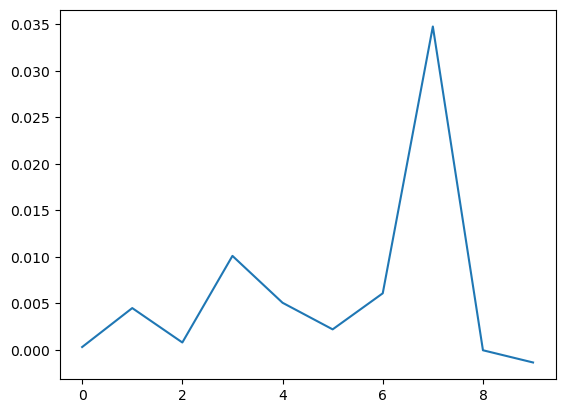

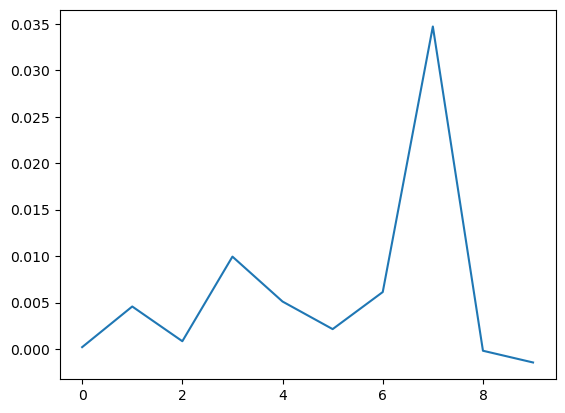

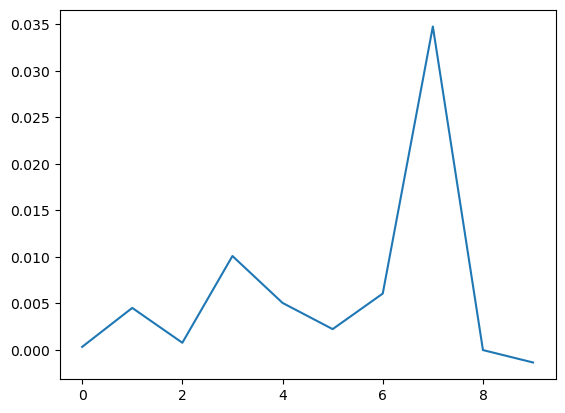

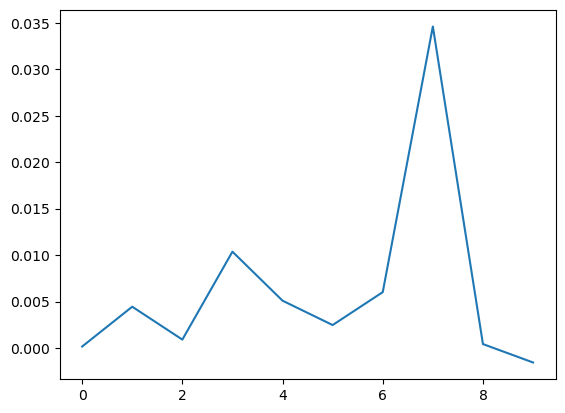

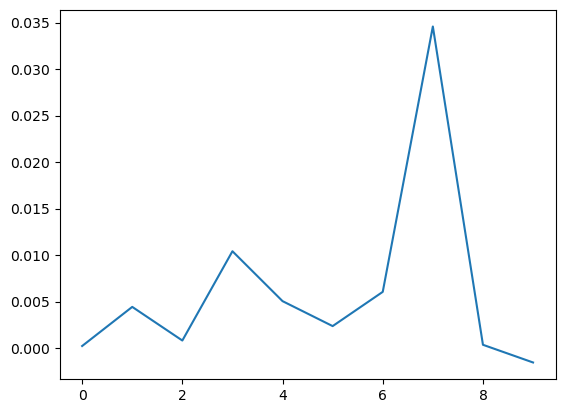

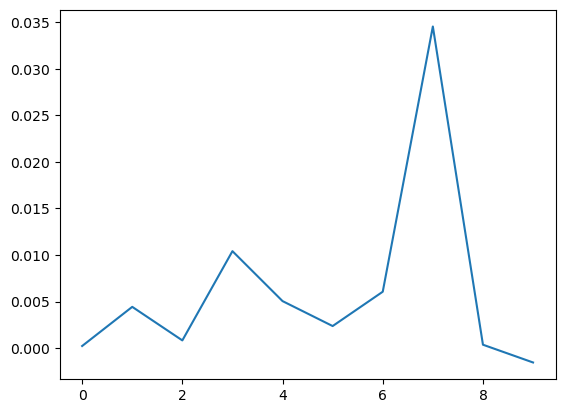

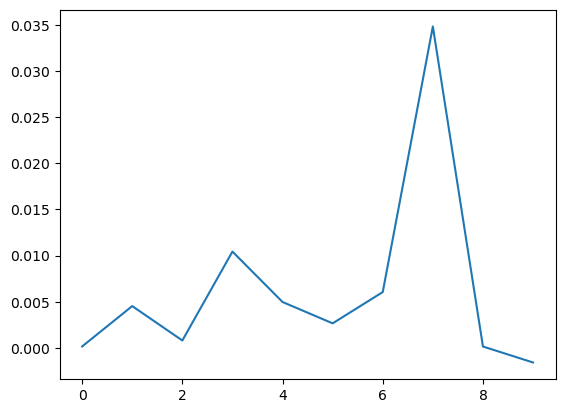

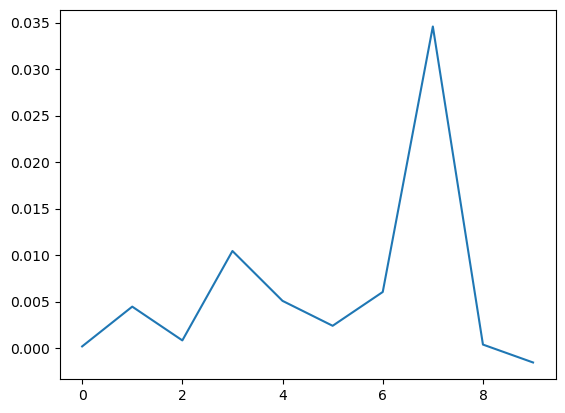

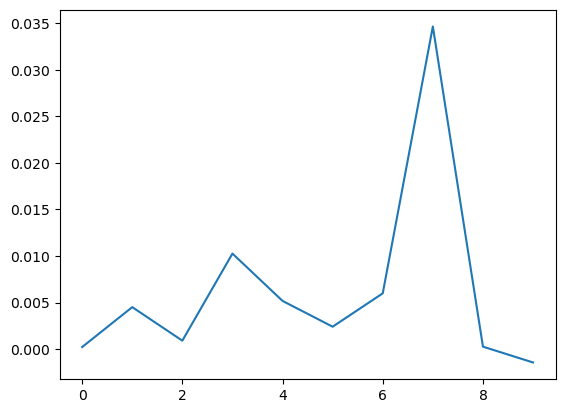

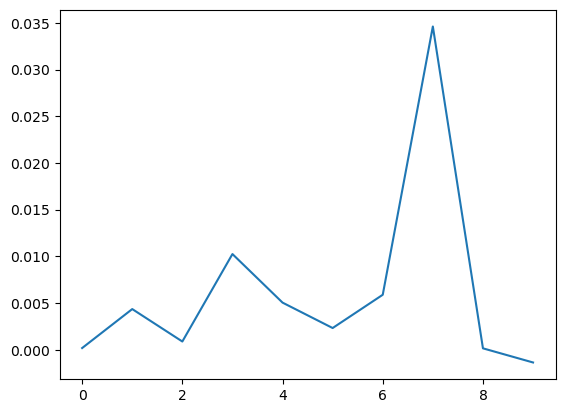

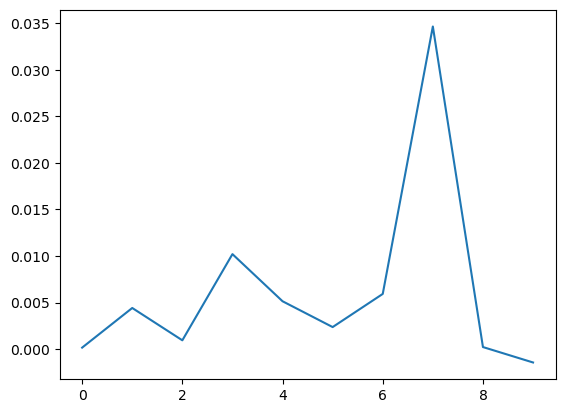

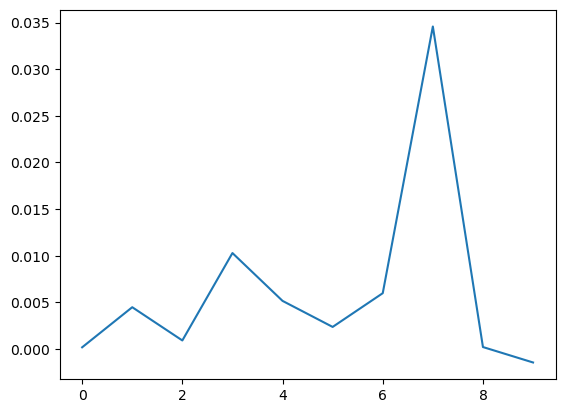

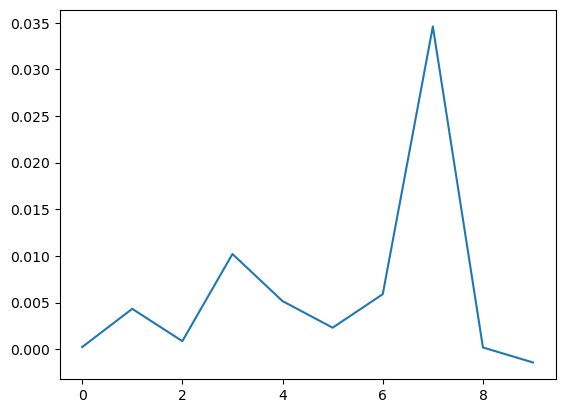

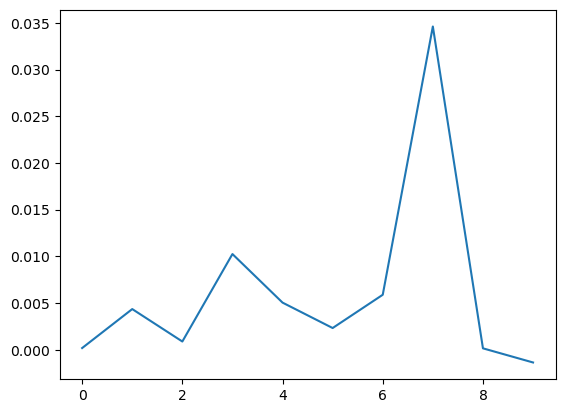

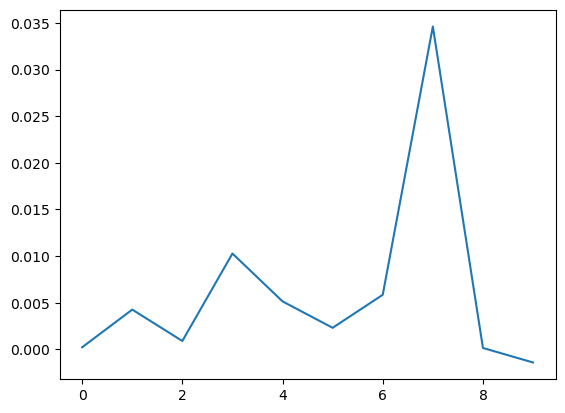

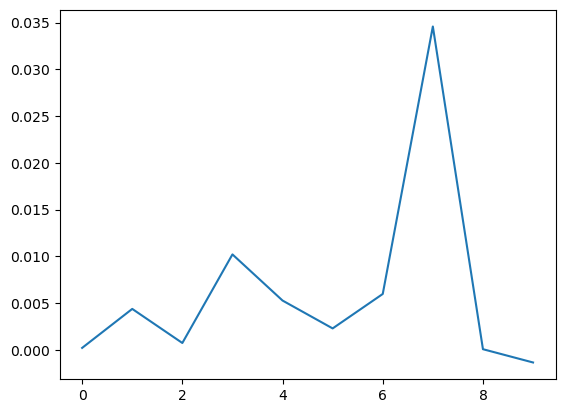

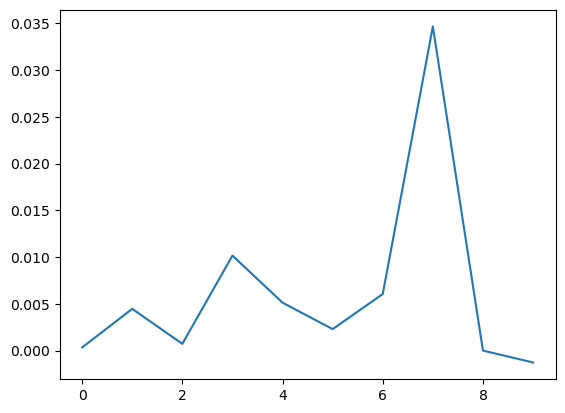

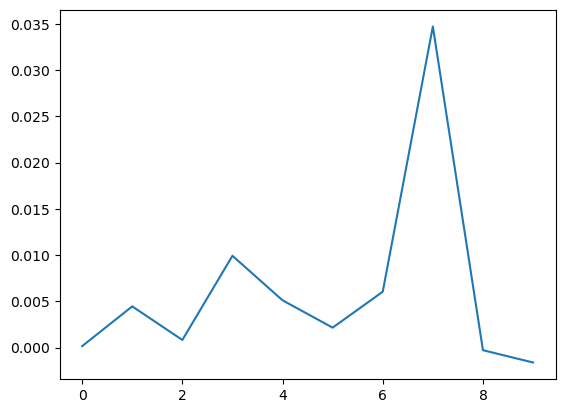

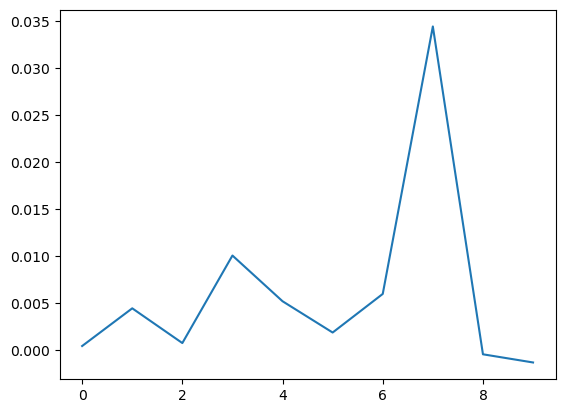

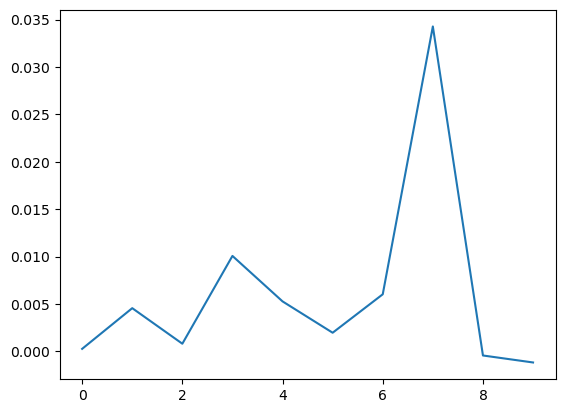

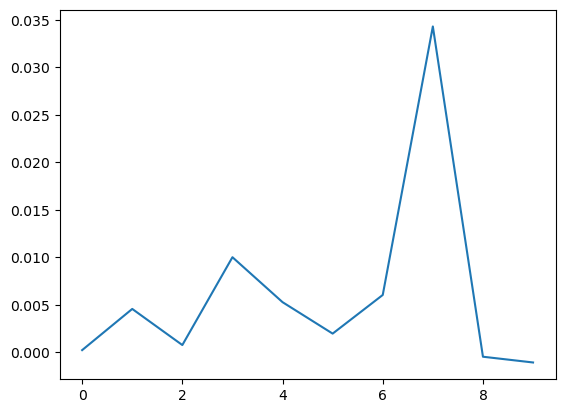

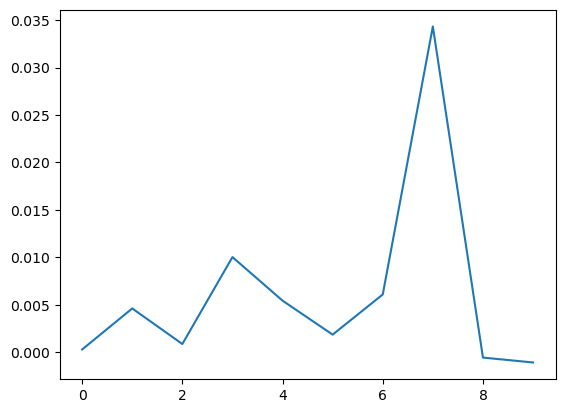

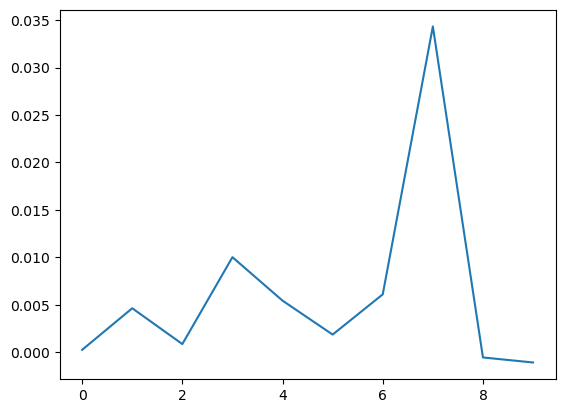

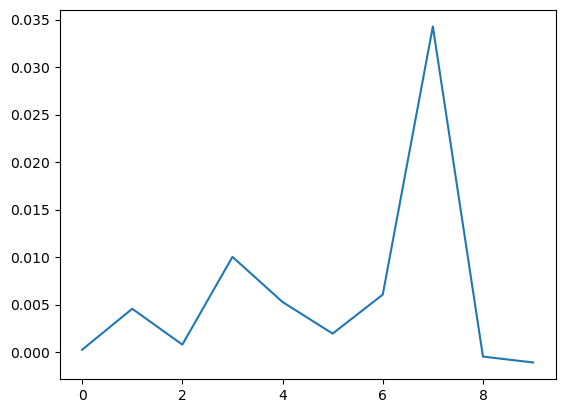

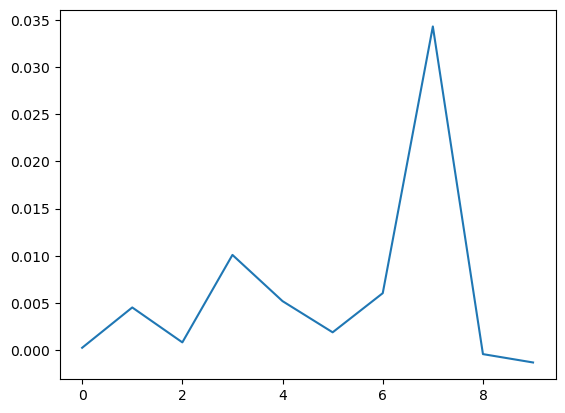

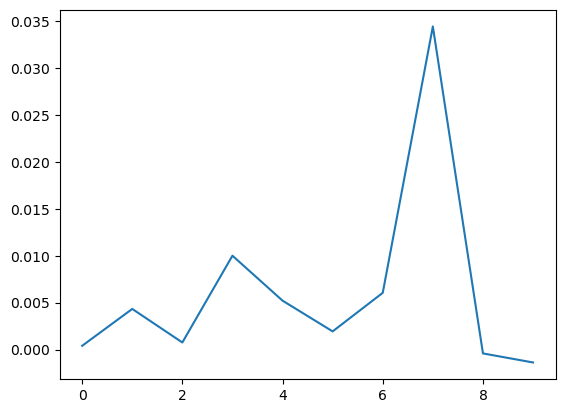

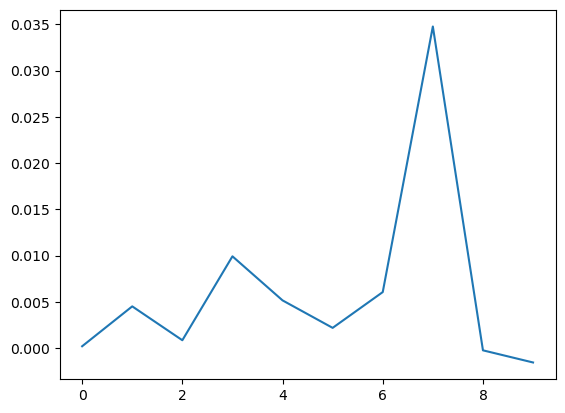

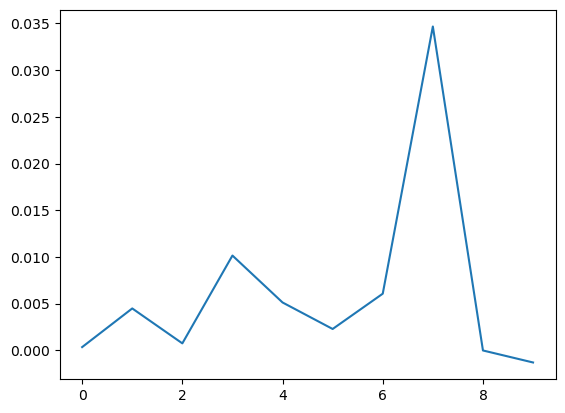

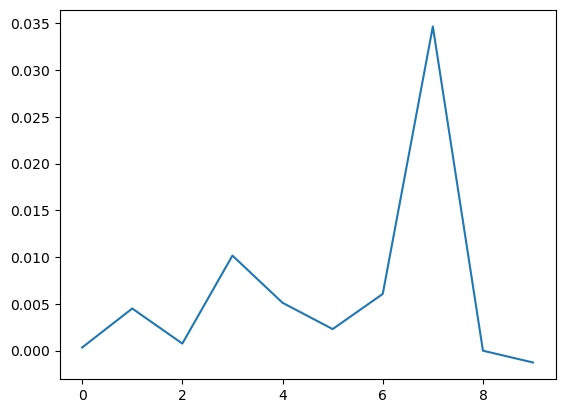

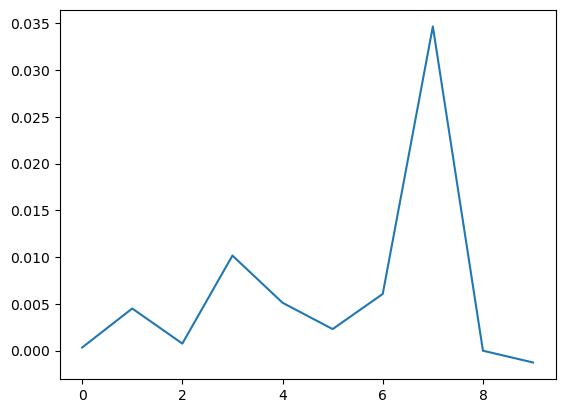

In [14]:
import matplotlib.pyplot as plt
for i in range(30):
    plt.plot(prediction[i].cpu().numpy())
    plt.show()
